# MODELO: Neural-Prophet

## Predicción de Consumo de Agua mediante NeuralProphet

Este notebook implementa un modelo de predicción de consumo de agua utilizando NeuralProphet, una arquitectura híbrida que combina redes neuronales con los principios de Prophet. El objetivo es predecir patrones de consumo de agua a nivel individual basándonos en datos agregados por clusters.

### Descripción del Proceso

1. **Preparación de Datos**
   - Utilizamos datos agregados que representan las medias de consumo diario por cluster
   - Aplicamos suavizado mediante acumulado móvil de 30 días para reducir el ruido en los datos
   - Los datos se normalizan para optimizar el entrenamiento del modelo

2. **Modelado**
   - Implementación de NeuralProphet
   - Entrenamiento con datos agregados por cluster
   - Validación del modelo durante el entrenamiento

3. **Evaluación**
   - Testing sobre consumidores individuales
   - Análisis del comportamiento del modelo en casos específicos
   - Métricas de rendimiento y visualización de resultados

### Objetivo
El propósito es desarrollar un modelo que, habiendo aprendido patrones generales de clusters de consumidores, sea capaz de realizar predicciones precisas a nivel individual, facilitando así la gestión y planificación del consumo de agua.

### Aplicación
Este modelo podrá ser utilizado para:
- Planificación de recursos hídricos
- Optimización de la distribución de agua


In [1]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import glob
import warnings
import logging

# Desactiva los warnings y ajusta el logging
warnings.filterwarnings("ignore")
logging.getLogger("NP").setLevel(logging.ERROR)

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


#### 1. Carga de datos

Cargamos los datos de alguno de los clusters con sus respectivas muestras. Los datos estan organizados por días y de cada día se tiene la media de consumo de todos los usuarios en ese día. Las medias se han calculado en función de la cantidad de usuarios que hay para ese día, no para el total de usuarios, es decir habrán días que cuenten con 60 usuarios y otros con solo 3 por ejemplo.

In [2]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('predictions_dia_avg_v3/predictions_0.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

df = df.rename(columns={'day': 'ds', 'avg_all_users': 'y'})

# Asumiendo que tu DataFrame se llama 'df'

# Primero, asegúrate de que 'ds' es de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Luego, elimina la información de zona horaria
df['ds'] = df['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df['ds'].dtype)

df = df.sort_values('ds')

df.head()

datetime64[ns]


,ds,y
0,2021-01-01,0.004155
1,2021-01-02,0.004065
2,2021-01-03,0.004092
3,2021-01-04,0.004433
4,2021-01-05,0.004407


Para suavizar los datos, se calcula el acumulado movil de cada día teniendo en cuenta los 30 días anteriores:

In [3]:
df['acumulado_movil_30'] = df['y'].rolling(window=30).sum()
df

,ds,y,acumulado_movil_30
0,2021-01-01,0.004155,NaN
1,2021-01-02,0.004065,NaN
2,2021-01-03,0.004092,NaN
3,2021-01-04,0.004433,NaN
4,2021-01-05,0.004407,NaN
...,...,...,...
1196,2024-04-11,0.006914,0.202115
1197,2024-04-12,0.006723,0.201863
1198,2024-04-13,0.006697,0.201676
1199,2024-04-14,0.006839,0.201797


Seguidamente se filtran los datos para entrenar el modelo. 
- Quitamos los datos que contiene la media acumulada nula ya que no hay valores anteriores para calcularla
- Las fechas de división entre train y test se deciden en base a la cantidad de contadores que queramos tener posteriormente para realizar el testing.

In [4]:
df = df[df["ds"] >= "2021-01-31 00:00:00"] # Quitamos datos que tienen la media acumulada Nula
df = df[df["ds"] < "2024-01-01 00:00:00"]

Graficamos tanto los datos originales como los datos tras realizar el cálculo del acumulado móvil:

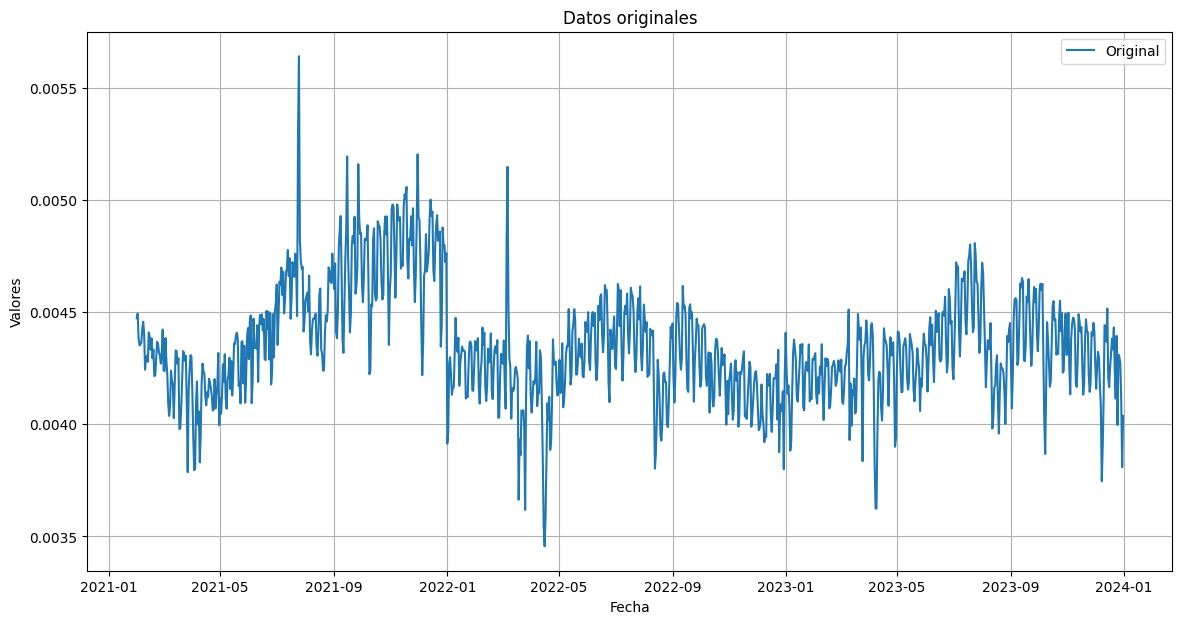

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df["ds"], df["y"], label="Original")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Datos originales")
plt.legend()
plt.grid()
plt.show()

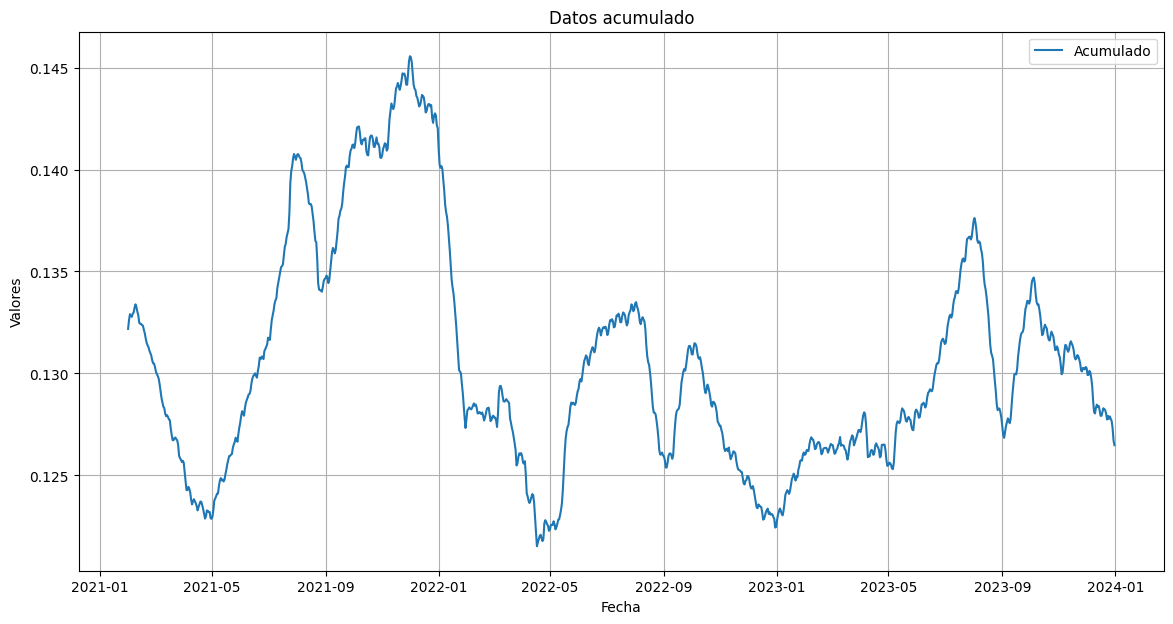

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df["ds"], df["acumulado_movil_30"], label="Acumulado")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Datos acumulado")
plt.legend()
plt.grid()
plt.show()

Adaptamos el dataframe para seguir con el formato necesario para trabajar con NeuralProphet, elimnando y renombrando columnas:

In [7]:
df = df.drop(columns=['y'])
df = df.rename(columns={'acumulado_movil_30': 'y'})

In [10]:
#Se crean los conjuntos de entrenamiento y test
#Datos de entrenamiento son los anteriores a junio 2023
df_data_train = df[df["ds"] < "2023-06-01 00:00:00"] 

#Datos de test son los posteriores a junio 2023 y anteriores a enero 2024
df_data_test = df[df["ds"] >= "2023-06-01 00:00:00"]
df_data_test = df_data_test[df_data_test["ds"] < "2024-01-01 00:00:00"]

df_data_test

,ds,y
881,2023-06-01,0.128165
882,2023-06-02,0.128045
883,2023-06-03,0.127827
884,2023-06-04,0.127861
885,2023-06-05,0.128151
...,...,...
1090,2023-12-27,0.127784
1091,2023-12-28,0.127661
1092,2023-12-29,0.127317
1093,2023-12-30,0.126710


In [11]:
df_data_train

,ds,y
30,2021-01-31,0.132185
31,2021-02-01,0.132614
32,2021-02-02,0.132906
33,2021-02-03,0.132826
34,2021-02-04,0.132775
...,...,...
876,2023-05-27,0.127243
877,2023-05-28,0.127214
878,2023-05-29,0.127633
879,2023-05-30,0.128098


Graficamos los datos de train y de prueba:

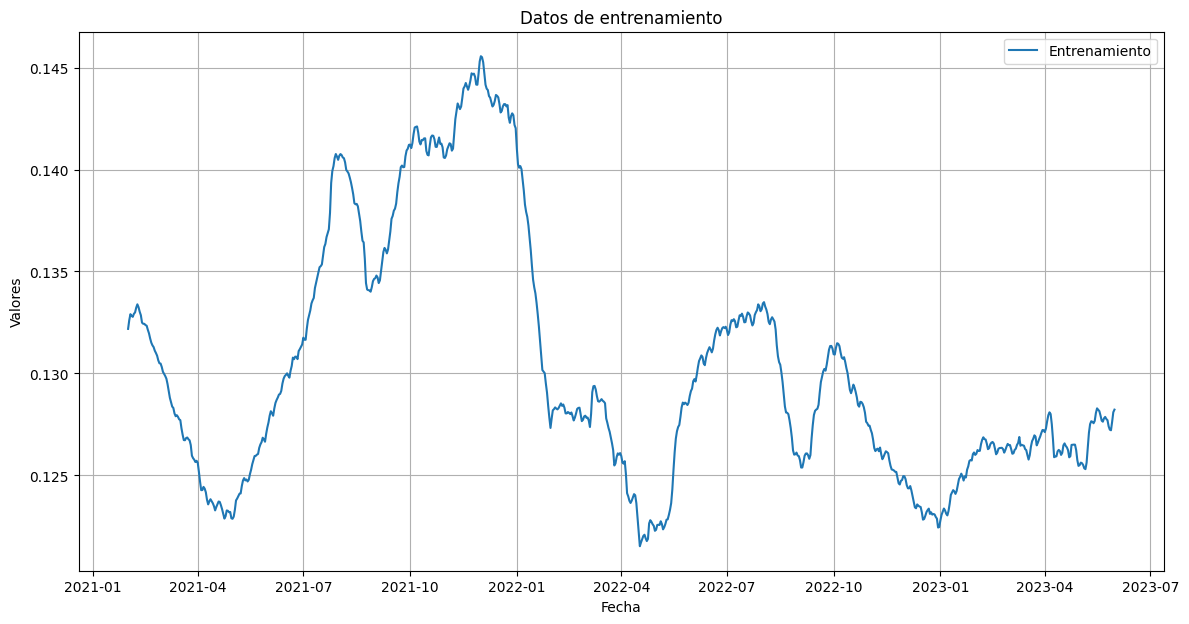

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(df_data_train["ds"], df_data_train["y"], label="Entrenamiento")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Datos de entrenamiento")
plt.legend()
plt.grid()
plt.show()

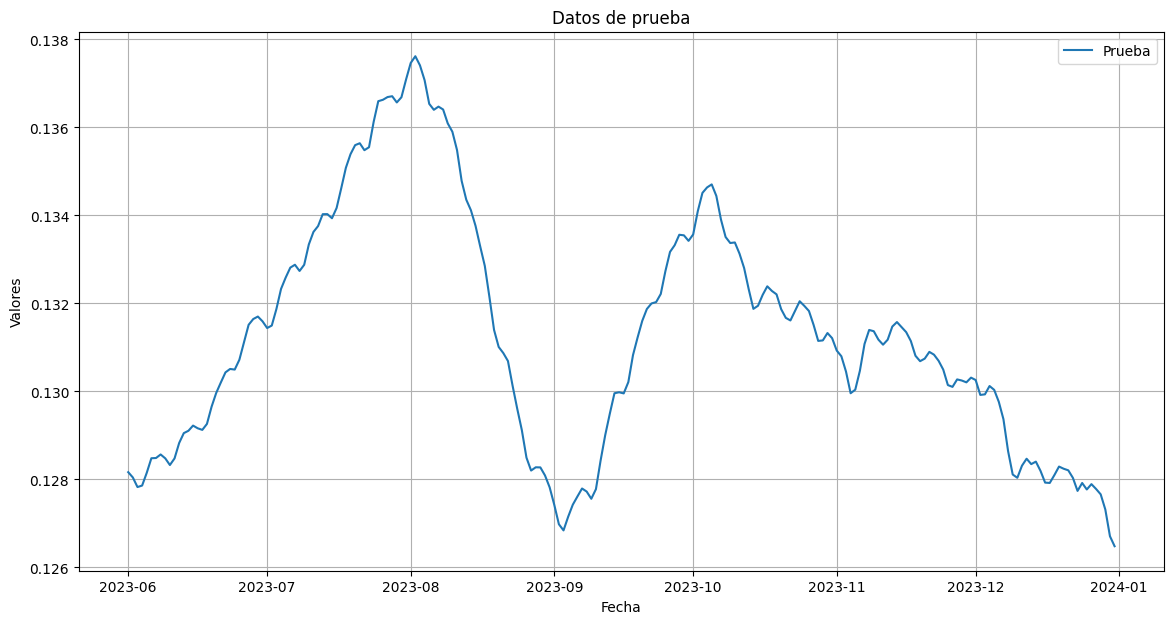

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(df_data_test["ds"], df_data_test["y"], label="Prueba")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Datos de prueba")
plt.legend()
plt.grid()
plt.show()

### 2. Entrenamiento del modelo

Entrenamos el modelo con una selección de parámetros concreta, se han realizado varias pruebas para finalmente elegir estos parámetros que parecen ser los que mejor se ajustan a nuestros datos.

Para diferentes conjuntos de datos sería interesante ajustar el learning rate para intentar conseguir mejores resultados.

In [15]:
# 1. Crear y entrenar el modelo NeuralProphet con configuración ajustada
model_global = NeuralProphet(
    n_forecasts=30,        # 30 días hacia adelante
    n_lags=60,             # Reducido a 60 para equilibrar rendimiento y captura de patrones
    yearly_seasonality=True,  # Estacionalidad anual automática
    weekly_seasonality=True,  # Estacionalidad semanal automática
    daily_seasonality=False,  # Desactivada para datos diarios
    seasonality_mode='multiplicative',  # Modo multiplicativo para estacionalidad
    batch_size=64,          # Tamaño de batch para un entrenamiento más eficiente
    epochs=100,             # Número de épocas para el entrenamiento
    learning_rate=0.001,    # Tasa de aprendizaje reducida para una convergencia más estable
    loss_func='Huber',      # Función de pérdida Huber para mayor robustez
    normalize='auto',       # Normalización automática de los datos
    impute_missing=True,    # Imputar valores faltantes automáticamente
    growth='linear',        # Crecimiento lineal
    n_changepoints=10,      # Número de puntos de cambio para capturar tendencias no lineales
    changepoints_range=0.9, # Rango de puntos de cambio (0-1)
    seasonality_reg=0.1,    # Regularización de la estacionalidad
)
model_global.add_country_holidays(country_name="ES")
model_global.set_plotting_backend("plotly-static")

# Entrenar el modelo
history = model_global.fit(df_data_train, freq="D")
history

2024-12-02 15:08:31.991851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733148512.009118 3784086 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733148512.014381 3784086 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 15:08:32.032633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,0.051291,0.065744,1.642360,0.00000,0
1,0.049443,0.063599,1.580035,0.00000,1
2,0.047594,0.061448,1.516728,0.00000,2
3,0.045640,0.059140,1.450978,0.00000,3
4,0.043589,0.056653,1.381588,0.00000,4
...,...,...,...,...,...
95,0.002509,0.003660,0.031882,0.00001,95
96,0.002509,0.003649,0.031900,0.00001,96
97,0.002509,0.003661,0.031864,0.00001,97
98,0.002505,0.003657,0.031793,0.00001,98


Predicting: 12it [00:00, ?it/s]

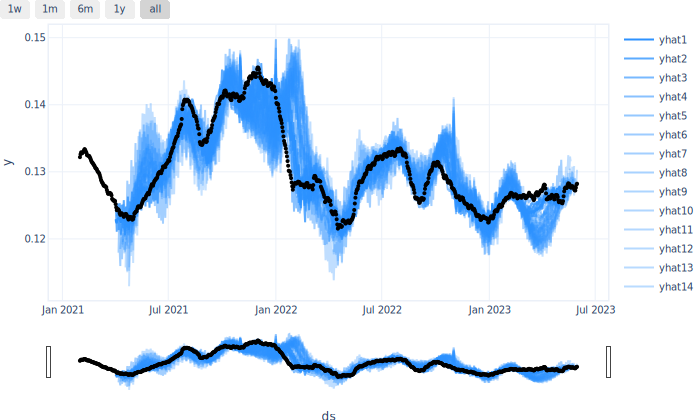

In [16]:
forecast = model_global.predict(df_data_train)
model_global.plot(forecast)

In [17]:
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,...,event_All Saints' Day,event_Assumption Day,event_Christmas Day,event_Constitution Day,event_Epiphany,event_Good Friday,event_Immaculate Conception,event_Labor Day,event_National Day,event_New Year's Day
0,2021-01-31,0.132185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-01,0.132614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-02,0.132906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-03,0.132826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-04,0.132775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,2023-05-27,0.127243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
847,2023-05-28,0.127214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
848,2023-05-29,0.127633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
849,2023-05-30,0.128098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
forecast = forecast.dropna(subset=['yhat1'])
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,...,event_All Saints' Day,event_Assumption Day,event_Christmas Day,event_Constitution Day,event_Epiphany,event_Good Friday,event_Immaculate Conception,event_Labor Day,event_National Day,event_New Year's Day
60,2021-04-01,0.125627,0.122750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
61,2021-04-02,0.125185,0.122787,0.125864,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,-0.000089,0.0,0.000000,0.0,0.0
62,2021-04-03,0.124697,0.122472,0.122509,0.123431,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
63,2021-04-04,0.124277,0.122340,0.121065,0.123447,0.124677,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
64,2021-04-05,0.124283,0.122803,0.125025,0.123521,0.124732,0.123594,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,2023-04-28,0.126242,0.127328,0.127249,0.125068,0.125669,0.125047,0.125649,0.127541,0.125780,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
818,2023-04-29,0.125751,0.127491,0.125972,0.124516,0.125473,0.125307,0.125971,0.127230,0.125645,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
819,2023-04-30,0.125468,0.127887,0.125760,0.124860,0.125383,0.126100,0.126753,0.130294,0.125869,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
820,2023-05-01,0.125504,0.127861,0.127685,0.125626,0.125731,0.126851,0.127548,0.130902,0.126305,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000269,0.0,0.0


### 3. Evaluación

#### 3.1 Interpretación de las métricas
- MAE (Mean Absolute Error):

Representa el error promedio en unidades del objetivo (en este caso, la escala de consumo de agua).
Ejemplo: Un MAE de 0.5 significa que las predicciones tienen un error promedio de 0.5 unidades.

- RMSE (Root Mean Squared Error):

Similar al MAE, pero penaliza más los errores grandes.
Un RMSE más alto que el MAE indica que hay outliers o errores grandes en algunas predicciones.

- MAPE (Mean Absolute Percentage Error):

Representa el error como un porcentaje del valor real.
Ejemplo: Un MAPE de 5% indica que las predicciones son, en promedio, un 5% diferentes de los valores reales.

MAE: 0.0018
RMSE: 0.0022
MAPE: 1.39%


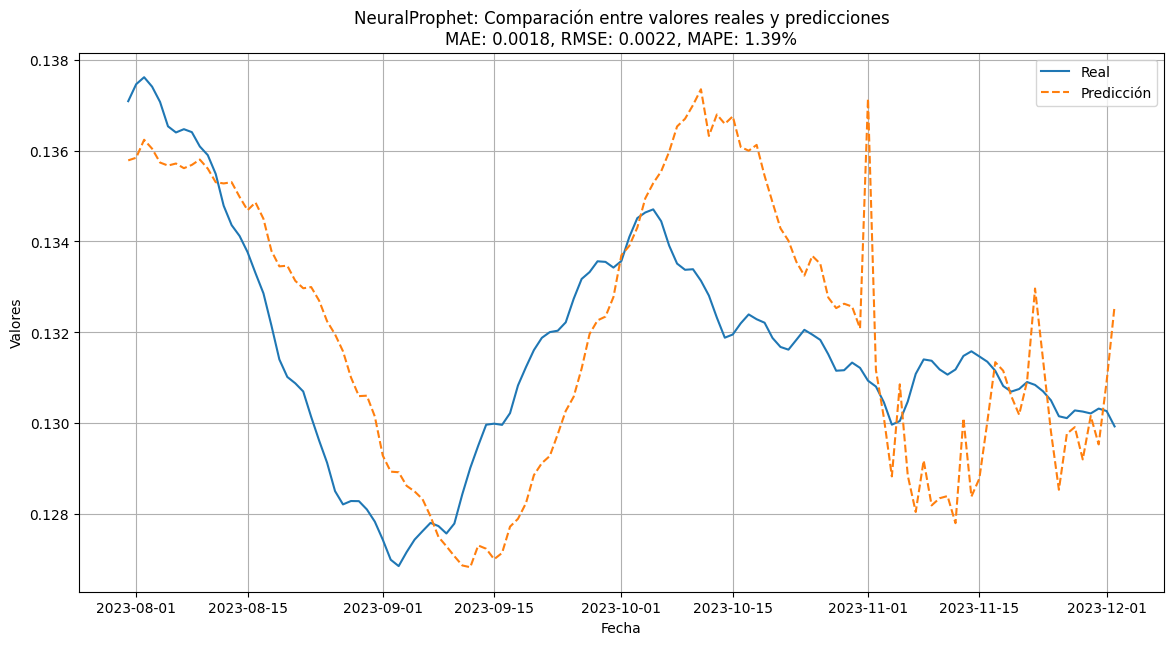

In [48]:
# Calcular métricas
mae = mean_absolute_error(forecast["y"].dropna(), forecast["yhat1"].dropna())
rmse = mean_squared_error(forecast["y"].dropna(), forecast["yhat1"].dropna(), squared=False)

# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(forecast["y"].dropna(), forecast["yhat1"].dropna()) * 100

# 4. Imprimir métricas
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(forecast["ds"], forecast["y"], label="Real")
plt.plot(forecast["ds"], forecast["yhat1"], label="Predicción", linestyle="--")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"NeuralProphet: Comparación entre valores reales y predicciones\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
plt.legend()
plt.grid()
plt.show()

Probamos el modelo con los datos de prueba:

In [20]:
# 2. Realizar predicciones en el conjunto de prueba
# future = model_global.make_future_dataframe(df_data_test, periods=1, n_historic_predictions=True)
forecast = model_global.predict(df_data_test)

forecast[['ds','y','yhat1']]

Predicting: 12it [00:00, ?it/s]

,ds,y,yhat1
0,2023-06-01,0.128165,NaN
1,2023-06-02,0.128045,NaN
2,2023-06-03,0.127827,NaN
3,2023-06-04,0.127861,NaN
4,2023-06-05,0.128151,NaN
...,...,...,...
209,2023-12-27,0.127784,NaN
210,2023-12-28,0.127661,NaN
211,2023-12-29,0.127317,NaN
212,2023-12-30,0.126710,NaN


In [21]:
forecast = forecast.dropna(subset=['yhat1'])
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,...,event_All Saints' Day,event_Assumption Day,event_Christmas Day,event_Constitution Day,event_Epiphany,event_Good Friday,event_Immaculate Conception,event_Labor Day,event_National Day,event_New Year's Day
60,2023-07-31,0.137090,0.135786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,2023-08-01,0.137464,0.135843,0.135723,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,2023-08-02,0.137618,0.136239,0.134710,0.135914,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,2023-08-03,0.137410,0.136043,0.135242,0.136165,0.136595,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,2023-08-04,0.137074,0.135737,0.136089,0.136182,0.137045,0.136046,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2023-11-28,0.130248,0.129193,0.131525,0.132975,0.132671,0.132797,0.131244,0.128973,0.132187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,2023-11-29,0.130207,0.130150,0.129216,0.131824,0.131073,0.129914,0.130539,0.128570,0.131877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,2023-11-30,0.130314,0.129524,0.130619,0.132507,0.131735,0.131648,0.131451,0.132396,0.133199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,2023-12-01,0.130260,0.130910,0.131919,0.131769,0.132832,0.131255,0.130844,0.129350,0.132225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Creamos un nuevo dataframe con las predicciones obtenidas para los datos de test junto con los datos reales, y eliminanos las predicciones sin valores reales para que no interfieran a la hora de calcular el error producido:

In [22]:
# 3. Extraer predicciones y valores reales para calcular métricas
results_df = forecast[["ds", "yhat1"]].merge(df_data_test, on="ds", how="left")
results_df.rename(columns={"yhat1": "y_pred", "y": "y_real"}, inplace=True)
results_df

,ds,y_pred,y_real
0,2023-07-31,0.135786,0.137090
1,2023-08-01,0.135843,0.137464
2,2023-08-02,0.136239,0.137618
3,2023-08-03,0.136043,0.137410
4,2023-08-04,0.135737,0.137074
...,...,...,...
120,2023-11-28,0.129193,0.130248
121,2023-11-29,0.130150,0.130207
122,2023-11-30,0.129524,0.130314
123,2023-12-01,0.130910,0.130260


In [23]:
results_df = results_df[results_df["ds"] >= "2023-07-01"] 
# Eliminar filas donde la columna 'yhat' tenga valores NaN
results_df = results_df.dropna(subset=['y_real'])

results_df

,ds,y_pred,y_real
0,2023-07-31,0.135786,0.137090
1,2023-08-01,0.135843,0.137464
2,2023-08-02,0.136239,0.137618
3,2023-08-03,0.136043,0.137410
4,2023-08-04,0.135737,0.137074
...,...,...,...
120,2023-11-28,0.129193,0.130248
121,2023-11-29,0.130150,0.130207
122,2023-11-30,0.129524,0.130314
123,2023-12-01,0.130910,0.130260


In [47]:
# Calcular métricas
mae = mean_absolute_error(results_df["y_real"].dropna(), results_df["y_pred"].dropna())
rmse = mean_squared_error(results_df["y_real"].dropna(), results_df["y_pred"].dropna(), squared=False)

# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(results_df["y_real"].dropna(), results_df["y_pred"].dropna()) *100

# 4. Imprimir métricas
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.0018
RMSE: 0.0022
MAPE: 1.39%


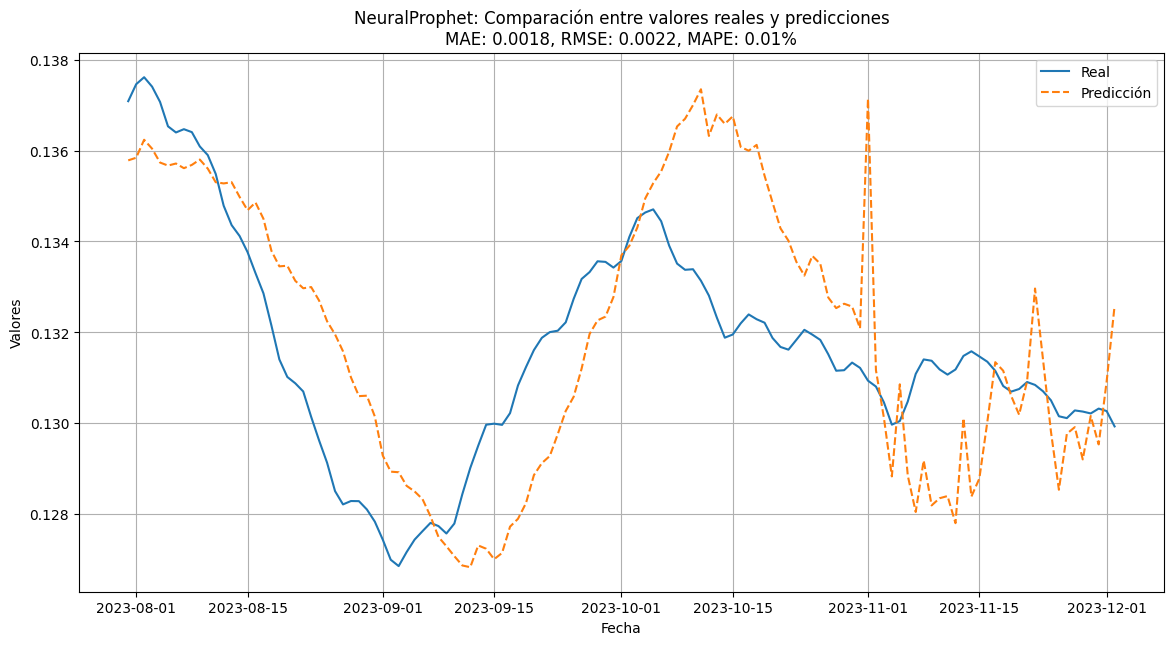

In [25]:
# 5. Graficar resultados
plt.figure(figsize=(14, 7))
plt.plot(results_df["ds"], results_df["y_real"], label="Real")
plt.plot(results_df["ds"], results_df["y_pred"], label="Predicción", linestyle="--")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"NeuralProphet: Comparación entre valores reales y predicciones\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
plt.legend()
plt.grid()
plt.show()

# # Guardar resultados en CSV
# results_df.to_csv("resultados_neuralprophet.csv", index=False)

Como podemos observar para todos los clusters los modelos funcionan bastante bien. En estos casos predicen el valor medio por día de todos los usuarios por cluster. El reto es comprobar como se comporta el modelo entrenado con los datos de los usuarios individuales que hemos apartado para test, ya que no es viable crear modelos individuales para cada uno de ellos ya que hay muchos.

### 4. Cargamos datos usuario concreto:

In [26]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('data_testing/cluster_0_sum_V3.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df = df.rename(columns={'day': 'ds', 'sum_value': 'y', 'serial_number': 'user_id'})

# Asumiendo que tu DataFrame se llama 'df'

# Primero, asegúrate de que 'ds' es de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Luego, elimina la información de zona horaria
df['ds'] = df['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df['ds'].dtype)

df_users = df.sort_values('ds')
df_users.head()

datetime64[ns]


,ds,user_id,y
3916262,2021-01-01,J18YA005244,0.100
3918582,2021-01-01,J18YA010627,0.001
3918583,2021-01-01,J18YA010628,0.073
3918584,2021-01-01,J18YA010629,0.000
3918585,2021-01-01,J18YA010630,0.191


In [27]:
# Filtrar las filas dentro del rango de fechas deseado (2020-01-01 a 2024-12-31)
filtered_df = df_users[(df_users['ds'] >= '2020-01-01') & (df_users['ds'] <= '2024-12-31')]
filtered_df

,ds,user_id,y
3916262,2021-01-01,J18YA005244,0.100
3918582,2021-01-01,J18YA010627,0.001
3918583,2021-01-01,J18YA010628,0.073
3918584,2021-01-01,J18YA010629,0.000
3918585,2021-01-01,J18YA010630,0.191
...,...,...,...
1567164,2024-04-15,I20EA210859,0.000
1567163,2024-04-15,I20EA210858,0.167
1567162,2024-04-15,I20EA210857,0.223
1567160,2024-04-15,I20EA210855,0.218


Comprobamos la cantidad de usuarios que hay para cada selección de años que decidamos, con el objetivo de asegurarnos de que disponeongamos de datos suficientes para cada uno de ellos.

In [28]:
# Agregar una columna con el año para verificar la cobertura por usuario
filtered_df['year'] = filtered_df['ds'].dt.year

# Verificar que cada usuario tenga datos en todos los años entre 2020 y 2024
valid_users = (
    filtered_df.groupby('user_id')['year']
    .apply(lambda years: set(years) >= {2021, 2022, 2023, 2024})
)

# Filtrar los usuarios válidos
valid_user_ids = valid_users[valid_users].index  # Índices de los usuarios válidos

# Obtener las filas originales correspondientes a esos usuarios
result_df = df[df['user_id'].isin(valid_user_ids)]

valid_user_ids

Index(['05564568', '05564570', '05564571', '05566806', '08FE049641',
       '11JE094391', '11SD077437', '12SC113035', '12SE112419', '12UD117186',
       ...
       'S20ZA000379I', 'S20ZA000380', 'WM1039_0050720', 'WM1039_0169035',
       'XP18VA021292N', 'XP18VA129398I', 'XP18VA129412P', 'XP18VA129434V',
       'XP18VA129446', 'XP18VA129873O'],
      dtype='object', name='user_id', length=11117)

In [29]:
len(valid_user_ids)

11117

Seleccionamos un usuario:

In [30]:
# Filtrar por serial_number de interés
serial_to_predict = "12SE112419"  # Serial que quieres predecir #I21EA274468 cluster 7
df_filtered = df_users[df_users['user_id'] == serial_to_predict]
df_filtered = df_filtered.sort_values('ds')
df_filtered.head()

,ds,user_id,y
5184541,2021-12-20,12SE112419,0.05
5196919,2021-12-21,12SE112419,0.12
5209319,2021-12-22,12SE112419,0.03
5221817,2021-12-23,12SE112419,0.09
5234435,2021-12-24,12SE112419,0.06


El procesamiento es el mismo que para los datos de entrenamiento del modelo, necesitamos obtener el acumulado móvilvil de los datos para el usuario seleccionado:

In [31]:
df_filtered['acumulado_movil_30'] = df_filtered['y'].rolling(window=30).sum()
df_filtered = df_filtered.drop(columns=['y'])
df_filtered = df_filtered.rename(columns={'acumulado_movil_30': 'y'})

In [32]:
df_filtered

,ds,user_id,y
5184541,2021-12-20,12SE112419,NaN
5196919,2021-12-21,12SE112419,NaN
5209319,2021-12-22,12SE112419,NaN
5221817,2021-12-23,12SE112419,NaN
5234435,2021-12-24,12SE112419,NaN
...,...,...,...
1482878,2024-04-11,12SE112419,2.326
1502298,2024-04-12,12SE112419,2.306
1521870,2024-04-13,12SE112419,2.336
1541369,2024-04-14,12SE112419,2.296


In [33]:
df_data_train_filter = df_filtered[df_filtered["ds"] < "2023-07-01"]
df_data_test_filter = df_filtered[df_filtered["ds"] >= "2023-07-01"] 
df_data_test_filter = df_data_test_filter[df_data_test_filter["ds"] < "2024-01-01"]

In [34]:
df_data_test_filter

,ds,user_id,y
8322736,2023-07-01,12SE112419,1.833
8334939,2023-07-02,12SE112419,1.773
8347009,2023-07-03,12SE112419,1.763
8359027,2023-07-04,12SE112419,1.903
8371062,2023-07-05,12SE112419,1.933
...,...,...,...
13925786,2023-12-27,12SE112419,1.500
13937810,2023-12-28,12SE112419,1.490
13949865,2023-12-29,12SE112419,1.460
13962005,2023-12-30,12SE112419,1.440


In [36]:
df_data_test_filter = df_data_test_filter[['ds','y']]
                        
future = model_global.make_future_dataframe(df_data_test_filter, periods=31, n_historic_predictions=True)  # 31 días 
forecast_user = model_global.predict(future)

forecast_user[['ds', 'y','yhat1']]

Predicting: 12it [00:00, ?it/s]

,ds,y,yhat1
0,2023-07-01,1.833,NaN
1,2023-07-02,1.773,NaN
2,2023-07-03,1.763,NaN
3,2023-07-04,1.903,NaN
4,2023-07-05,1.933,NaN
...,...,...,...
209,2024-01-26,NaN,NaN
210,2024-01-27,NaN,NaN
211,2024-01-28,NaN,NaN
212,2024-01-29,NaN,NaN


In [40]:
forecast_user = forecast_user.dropna(subset=['yhat1'])
forecast_user = forecast_user.dropna(subset=['y'])
forecast_user

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,...,event_All Saints' Day,event_Assumption Day,event_Christmas Day,event_Constitution Day,event_Epiphany,event_Good Friday,event_Immaculate Conception,event_Labor Day,event_National Day,event_New Year's Day
60,2023-08-30,1.66,1.416887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,2023-08-31,1.63,1.364046,1.592548,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,2023-09-01,1.49,1.463570,1.647603,1.530374,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,2023-09-02,1.42,1.371428,1.761889,1.562148,1.970809,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,2023-09-03,1.35,1.433635,1.667051,1.609924,1.665600,1.672244,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2023-12-27,1.50,2.248139,2.179980,1.749879,1.417869,1.546504,2.070804,1.269657,1.789976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,2023-12-28,1.49,2.159671,2.117184,1.411189,1.382814,1.468194,2.082865,1.526782,1.474883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,2023-12-29,1.46,2.187646,2.117144,1.267405,1.361668,1.701996,2.200757,1.686961,1.424061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,2023-12-30,1.44,2.198158,2.051460,1.268144,1.375832,1.779464,2.307164,2.046314,1.596171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Renombrar columnas para mayor claridad
results = forecast_user.rename(columns={'y': 'y_real', 'yhat1': 'y_pred'})

# Calcular el error absoluto y los porcentajes de error
results['error'] = results['y_real'] - results['y_pred']
results['abs_error'] = results['error'].abs()
results['abs_pct_error'] = (results['abs_error'] / results['y_real']) * 100  # Error porcentual

# Calcular las métricas
# MAE y RMSE con scikit-learn
y_real = results['y_real']
y_pred = results['y_pred']

mae = mean_absolute_error(y_real, y_pred)
rmse = mean_squared_error(y_real, y_pred, squared=False)  # RMSE
mape = mean_absolute_percentage_error(y_real, y_pred)*100

# 3. Mostrar resultados
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 0.3577711196984013
RMSE: 0.4898412274848363
MAPE: 19.228522814465897%


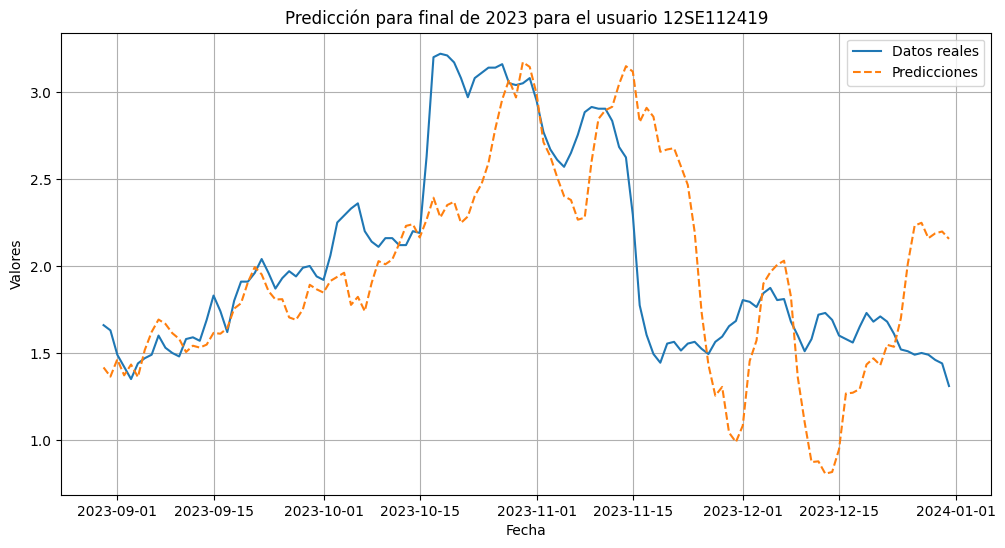

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate de que las fechas están en formato datetime
forecast_user['ds'] = pd.to_datetime(forecast_user['ds'])

# Graficar los datos reales y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(forecast_user['ds'], forecast_user['y'], label='Datos reales')  # Datos históricos
plt.plot(forecast_user['ds'], forecast_user['yhat1'], label='Predicciones', linestyle='dashed')  # Predicciones
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title(f'Predicción para final de 2023 para el usuario {serial_to_predict}')
plt.legend()
plt.grid()
plt.show()


El error se ha reducido gracias a la mejor selección de parámetros utilizados al entrenar el modelo de Neural-Prophet, sin embargo para estos datos parece que funcione mejor el modelo LSTM